# Описание задачи
## В задачи пректа входит:
- Обработка предоставленных данных: нахождение и заполнение пропусков, кодировка, нормализация признаков;
- Создание новых признаков с использованием предоставленных данных;
- Отбор признаков;
- Обучение и тестирование модели на полученных признаках;
- Оптимизация размера набора данных и подбор макропараметров модели на оптимизированном наборе;
- Получение предсказанных моделью значений, подготовка и отправка submission

## Описание датасета
Первоначальная версия датасета состоит из 14-ти столбцов, содержащих следующую информацию:

- **client_id** - идентификатор клиента
- **education** - уровень образования
- **sex** - пол заёмщика
- **age** - возраст заёмщика
- **car** - флаг наличия автомобиля
- **car**_type	флаг - автомобиля-иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия «хорошей» работы
- **bki_request_cnt** - количество запросов в БКИ
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заёмщика
- **foreign_passport** - наличие загранпаспорта
- **default** - наличие дефолта (целевая переменная)

# Импорт библиотек, установка параметров, определение функций

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

import os

In [151]:
# функции используемые в ноутбуке
def df_describe(df):
    desc = df.describe(include='all',percentiles=[0.5]).T
    desc['type'] = [type(x) for x in df.iloc[0]]
    desc['NaN'] = df.isna().sum()
    desc['not NaN'] = df.notna().sum()
    desc.unique = df.nunique()
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0] for col in  df.columns]
    return desc

def num_visualisation(row):
    min_diff = pd.Series(row.unique()).sort_values().diff().min()
    bins = int((row.max()-row.min()) / min_diff)
    bins_range = row.min()-min_diff/2 ,row.max()+min_diff/2 

    fig = plt.figure()
    
    ax1 = fig.add_axes([0, 0.35, 1, 1])
    row.plot.hist(bins=bins,density=True,alpha = 0.5)
    
    ax2 = fig.add_axes([0, 0, 1, 0.2]) 
    ax1.get_shared_x_axes().join(ax1, ax2)
    sns.boxplot(x=row)
    
    plt.tight_layout()

def nums_visualisation(df):
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '{}, '* (len(columns)-1) + '{}'
    print(('Всего числовых признаков {}. К ним относятся' + fstr).format(len(columns),*columns))


    indent = 0.05
    fig = plt.figure(figsize=(16,5))
    for i,col in enumerate(columns):
        row = df[col]
    
        fig.add_axes([1/cols_num*i, 0.35, 1/cols_num-indent, 1])
        plt.title(col)
        row.plot.hist()
    
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 0.2])
        sns.boxplot(x=row)

    plt.tight_layout()
    
def nums_vis(columns_name):
    print ("Всего числовых признаков {}. К ним относятся")
    fstr = '{}, '* (len(numerical_columns)-1) + '{}'
    print(('Всего числовых признаков {}. К ним относятся' + fstr).format(len(numerical_columns),*numerical_columns))
    pass

def pre_process(df):
    pass





In [3]:
# установка параметров
%pylab inline

pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

# альтернативные пути на kaggle и локальный (НЕ ЗАБЫВАТЬ МЕНЯТЬ!)
path = './Project_4_data/'
# path = '/kaggle/input/'

RANDOM_SEED = 42

Populating the interactive namespace from numpy and matplotlib


In [4]:
# проверка пути и имен файлов
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Project_4_data/train.csv


# Ознакомление с данными

In [5]:
# чтение данных

# df_train = pd.read_csv(f'{path}main_task.csv')
# df_test = pd.read_csv(f'{path}kaggle_task.csv')
# sample_submission = pd.read_csv(f'{path}sample_submission.csv')

data = pd.read_csv(f'{path}train.csv')

Проверим наличие дупликатов в данных

In [6]:
data.duplicated().sum()

0

Посмотрим на краткую сводку и простую статистику о наборе данных.

In [7]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Columns: 14 entries, client_id to default
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [8]:
df_describe(data)

,count,unique,top,freq,mean,std,min,50%,max,type,NaN,not NaN
client_id,73799,73799,1,1,55138,31841.9,1,55274,110147,<class 'numpy.int64'>,0,73799
education,73492,5,SCH,38860,NaN,NaN,NaN,NaN,NaN,<class 'str'>,307,73492
sex,73799,2,F,41562,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0,73799
age,73799,52,31,2727,39.2806,11.5204,21,37,72,<class 'numpy.int64'>,0,73799
car,73799,2,N,49832,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0,73799
car_type,73799,2,N,59791,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0,73799
decline_app_cnt,73799,21,0,61214,0.275749,0.804272,0,0,33,<class 'numpy.int64'>,0,73799
good_work,73799,2,0,61630,0.164894,0.371087,0,0,1,<class 'numpy.int64'>,0,73799
bki_request_cnt,73799,38,0,19381,2.00034,2.25207,0,1,53,<class 'numpy.int64'>,0,73799
home_address,73799,3,2,39956,1.57551,0.527631,1,2,3,<class 'numpy.int64'>,0,73799


Как видиим 9 признаков представлены числовым типом данных, 5 строковыми величинами. Из этих 5 "строковых" признаков 4 признака бинарных, один категориальный(5 категорий). В числовых признаках 5 признаков разумно отнести к численным (количество уникальных значений от 21 до 73799), два признака являются категориальными(в каждом 3 категории) и 2 признака бинарные.  

Пропуски встречаются только в одном признаке `education`. Их количество не велико и составляет менее 0,5% от количества наблюдений.  

Сравнивая количество уникальных значений **unique** и частоту  наиболее часто встречающейся категории **freq** можно заметь несбалансированность признаков по категориям. В `foreign_passport` `good_work` `decline_app_cnt` и `default` доля мажоритарной категории составляет около 6/7. Такой дисбаланс, особенно в целевой переменной `default` может создать проблемы при обучении модели. Нам придется предпринимать меры для устранения несбалансированности.

Посмотрим на сами данные

In [8]:
data.head(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0


Разделим признаки на количественные `num_cols` , категориальные `cat_cols` и бинарные `bin_cols`.     
К бинарным, очевидно, отнесем признаки с двумя уникальными значениями.   
Категориальными признаками будем считать признаки с количеством уникальных значений от 3 до 9  
Порогом для количественного признака будет наличие более чем 10 уникальных значений. 

In [9]:
num_uniq = data.nunique()
bin_cols = data.columns[num_uniq==2]
cat_cols = data.columns[(num_uniq>2) & (num_uniq<10)] 
num_cols = data.columns[num_uniq>=10]

# Работа с предоставленными данными
Сначала рассмотрим существующие признаки, выберем способы их предобработки, извлечем по возможности из существующих признаков информацию для создания новых.
Затем предобработаем существующие признаки согласно выбранным способам.
После этого создадим новые, при необходимости предобработаем и их.
## Числовые признаки

Всего числовых признаков 5. К ним относятсяclient_id, age, decline_app_cnt, bki_request_cnt, income


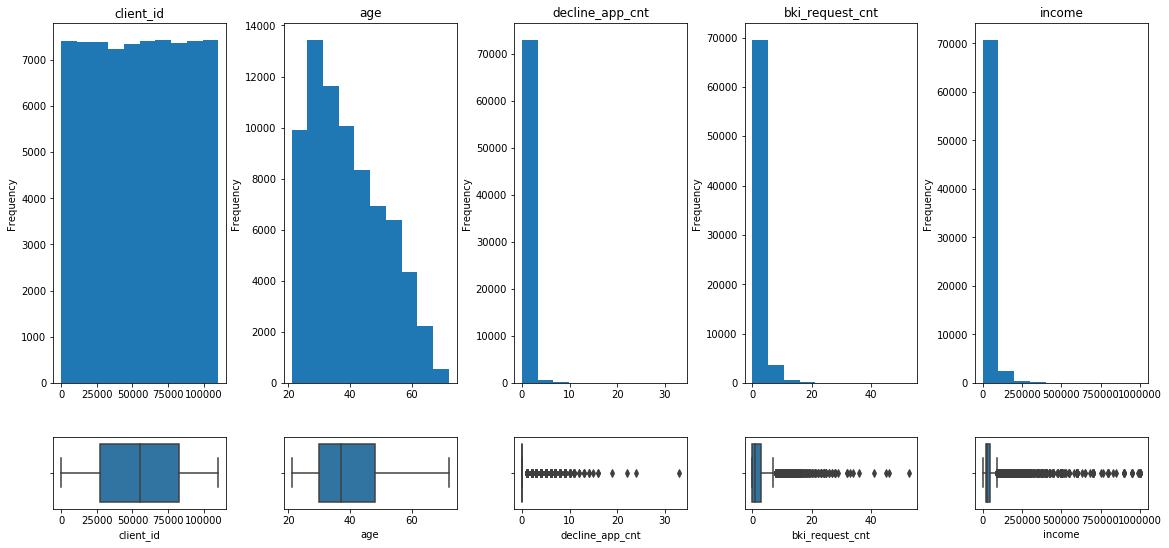

In [152]:
nums_visualisation(data[num_cols])

Как видим, кроме признака `client_id` признаки 

Всего числовых признаков 4. К ним относятсяage, decline_app_cnt, bki_request_cnt, income


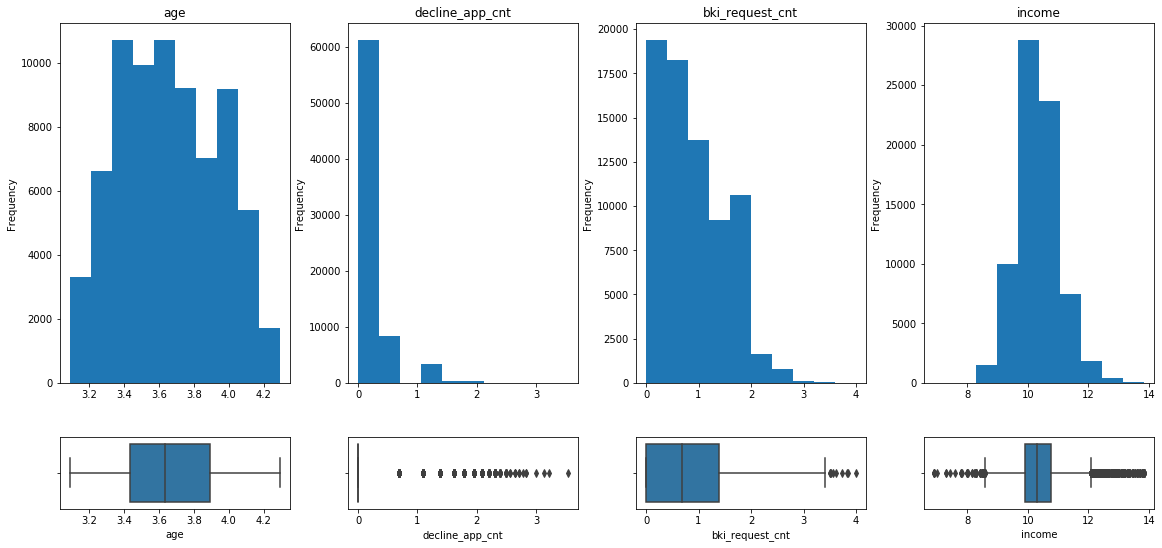

In [157]:
nums_visualisation(np.log(data[num_cols.drop('client_id')]+1))

### Age

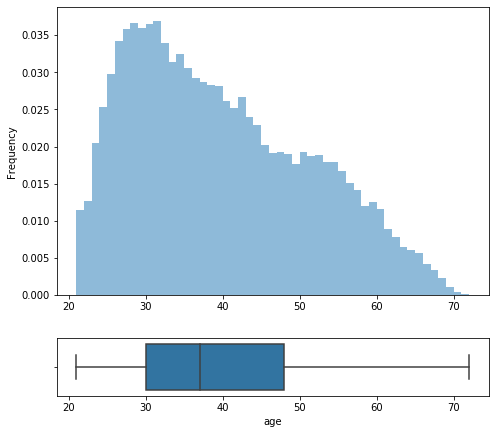

In [154]:
num_vis(data.age)

## Категориальные признаки

In [49]:
cat_cols

Index(['education', 'home_address', 'work_address'], dtype='object')

## Бинарные признаки

In [50]:
bin_cols

Index(['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default'], dtype='object')

## ПОДВАЛ


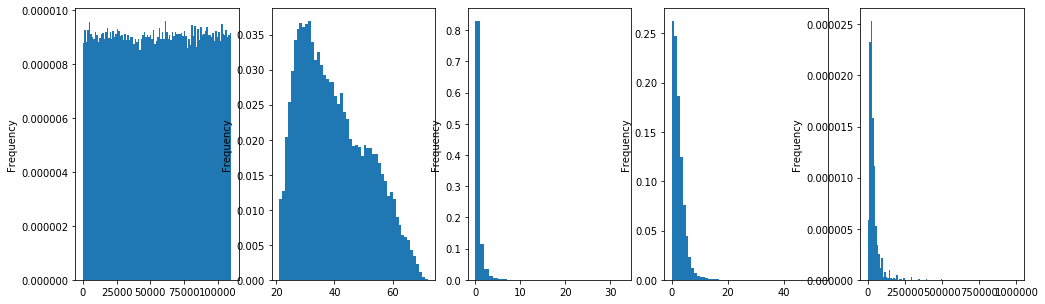

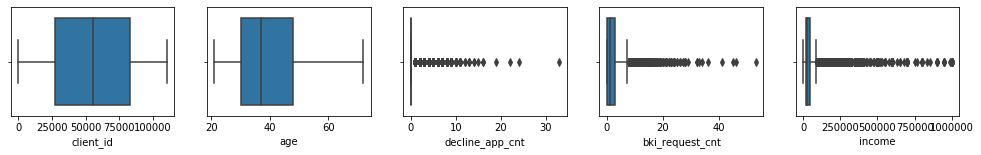

In [70]:
plt.figure(figsize=(17,5))
n_columns = len(columns)

for i,column in enumerate(columns):
    row = df[column]
    plt.subplot(1,n_columns,i+1)
    
    min_diff = pd.Series(row.unique()).sort_values().diff().min()
    bins = min(int((row.max()-row.min()) / min_diff),100)
    row.plot.hist(bins=bins,density=True)#(bins=bins,density=True,alpha = 0.5)

plt.figure(figsize=(17,2))
for i,column in enumerate(columns):  
    row = df[column]
    plt.subplot(1,n_columns,i+1)
    
    sns.boxplot(x=row)
